In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score

In [2]:
df = pd.read_csv('feverous.csv', names=["ID", "label", "claim", "evidence", "annotator_operations", "expected_challenge", "challenge"])

In [3]:
df = df.drop(0)

In [4]:
# Drop unnecessary columns
df = df[['label', 'claim']]

In [5]:
# Preprocess the data
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
X = df['claim']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Tokenize the text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [7]:
# Pad the sequences
X_train = pad_sequences(X_train, maxlen=100)
X_test = pad_sequences(X_test, maxlen=100)

In [8]:
# Build the model
model = Sequential()
model.add(Embedding(5000, 100, input_length=100))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          500000    
                                                                 
 conv1d (Conv1D)             (None, 98, 64)            19264     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                        

In [9]:
# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, callbacks=[early_stop])

Epoch 1/50
892/892 [==============================] - 17s 18ms/step - loss: 0.7975 - accuracy: 0.6147 - val_loss: 0.7587 - val_accuracy: 0.6279
Epoch 2/50
892/892 [==============================] - 17s 19ms/step - loss: 0.7165 - accuracy: 0.6623 - val_loss: 0.7569 - val_accuracy: 0.6228
Epoch 3/50
892/892 [==============================] - 16s 18ms/step - loss: 0.6308 - accuracy: 0.7250 - val_loss: 0.7697 - val_accuracy: 0.6347
Epoch 4/50
892/892 [==============================] - 15s 17ms/step - loss: 0.5258 - accuracy: 0.7817 - val_loss: 0.8431 - val_accuracy: 0.6214
Epoch 5/50
892/892 [==============================] - 17s 19ms/step - loss: 0.4301 - accuracy: 0.8250 - val_loss: 0.9437 - val_accuracy: 0.6230


In [10]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.6230


In [11]:
# Make predictions on the test set and calculate evaluation metrics
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

446/446 [==============================] - 2s 4ms/step


In [12]:
print(y_test.shape)
print(y_pred.shape)

(14259,)
(14259, 6)


In [13]:
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.09      0.01      0.02       464
           1       0.54      0.52      0.53      5495
           2       0.68      0.73      0.70      8300

    accuracy                           0.62     14259
   macro avg       0.43      0.42      0.42     14259
weighted avg       0.60      0.62      0.61     14259



Confusion Matrix:
[[   6  190  268]
 [  26 2834 2635]
 [  36 2221 6043]]


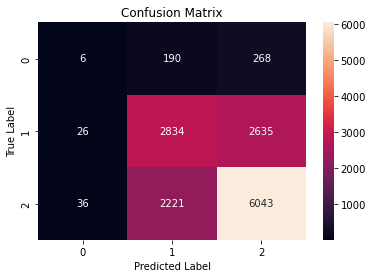

In [14]:
cm = confusion_matrix(y_test, y_pred_labels)
print(f'Confusion Matrix:\n{cm}')
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

C:\Users\shruti29\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\shruti29\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\shruti29\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


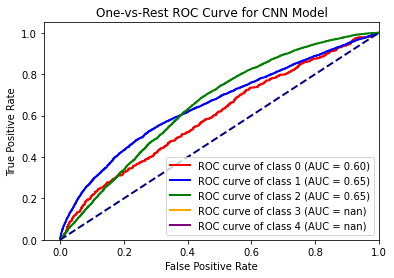

In [15]:
y_test.shape 
y_pred.shape 

n_classes = y_pred.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot one-vs-rest ROC curve for each class
plt.figure()
colors = ['red', 'blue', 'green', 'orange', 'purple'] # customize colors as needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curve for CNN Model')
plt.legend(loc="lower right")
plt.show()
